# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).

![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Calibrating and synthetic simulations of Rainfall with the STNSRPM.


In this script we calibrate the STNSRPM (Spatio Temporal Neyman Scott Rectangular Pulse Model) using several rainfall series from Tenerife Island with a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other things.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

### Load packages

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
import tqdm

In [26]:
import math as mt
from datetime import date
from datetime import timedelta
from scipy import stats

In [27]:
import sys
sys.path.insert(1, '../NEOPRENE/')

In [28]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.utils import compare_statistics, datetime2matlabdnJavi 
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.NSRP.Simulation import Simulation as Simulation_NSRP
from NEOPRENE.STNSRP.Simulation import Simulation

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import time
start_time = time.time()

### Loading daily rainfall for Tenerife Island (now for Sierra Nevada)

__Cuidado que las series tienen que ser coetáneas en el tiempo__

In [31]:
path_1 = './auxiliary-materials/SN/'

In [32]:
## Loading rainfall series
Series_SN = pd.read_csv(path_1 + 'DailySN.csv', index_col=0, parse_dates=True)
Series_SN[Series_SN.values<0]=np.nan
Input_Series=Series_SN.copy()
del Series_SN

In [33]:
## Loading attributes for the series
Attributes_SN = pd.read_csv(path_1 + 'AtributosSN.csv', index_col=0)
Input_Attr=pd.DataFrame()
Input_Attr['ID']=[str(i) for i in Attributes_SN.field_1.values]
Input_Attr['X']=Attributes_SN.Long.values
Input_Attr['Y']=Attributes_SN.Lat.values
Input_Attr['Elevation']=Attributes_SN.field_4.values
del Attributes_SN

In [34]:
Input_Attr = Input_Attr.iloc[0:5]

In [35]:
## Shorting ID series to match with Input_Attr
Input_Series = Input_Series[Input_Attr.ID]

<AxesSubplot:>

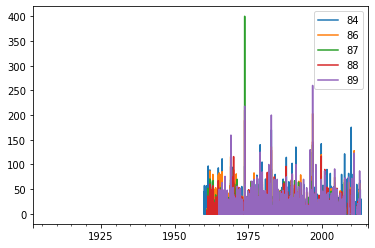

In [36]:
Input_Series.plot()

### Plotting rainfall series, seasonality and gauge position

Text(0, 0.5, 'mm/month')

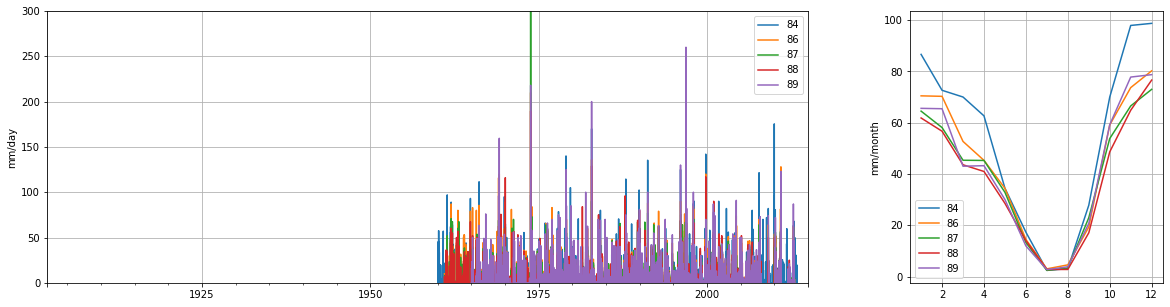

In [37]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Series.index.year[0]); t2=str(Input_Series.index.year[-1])
Input_Series.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Series.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Series>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

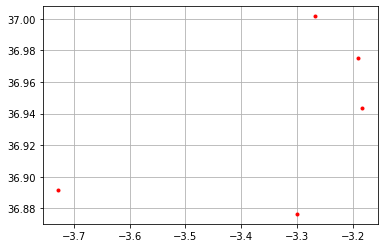

In [38]:
plt.plot(Input_Attr.X, Input_Attr.Y, '.r')
plt.grid()

### Calibration

Compleate...

In [39]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_SN.yml')

In [40]:
# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

# Input statistics from file 
#statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_Bilbao.csv')

In [41]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series, verbose=True)
CAL1.save_files('./CAL_SN/')#save python objects

[20, 1000]


################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)



Fitting the months = (1, 2, 3)

Initialization number  = 0
Initial best position  2.985327320713421 [4.30099640e-02 2.36529550e+01 1.51541923e+03 9.37494817e-01
 1.09361476e-01]
Iteration number  = 0
Total error = 2.985327320713421
Iteration number  = 1
Total error = 2.985327320713421
Iteration number  = 2
Total error = 1.6861230276282841
Iteration number  = 3
Total error = 1.6861230276282841
Iteration number  = 4
Total error = 1.6861230276282841
Iteration number  = 5
Total error = 1.6861230276282841
Iteration number  = 6
Total error = 1.6861230276282841
Iteration number  = 7
Total error = 1.6861230276282841
Iteration number  = 8
Total error = 1.6861230276282841
Iteration number  = 9
Total error = 1.2969520651923099
Iteration number  = 10
Total error = 1.249243411273626
Iteration number  = 11
Total error = 1.19455213313440

In [53]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_SN.yml')

In [58]:
SIM              = Simulation(hiper_params_sim) 
# Input parameters from the model

# SIM1             = SIM(params_cal = CAL1, Input_Series = Input_Series, Input_Attr = Input_Attr)

SIM1             = SIM(params_cal =['./CAL_SN/Calibrated_parameters.csv',
                                    './CAL_SN/xi_months.csv'], 
                       Input_Series = Input_Series, Input_Attr = Input_Attr)



################################################################################
Synthetic simulation


[-3.7584554447688525, 36.84606280523114]
[-3.153019645231147, 36.84606280523114]
[-3.153019645231147, 37.032051014768854]
[-3.7584554447688525, 37.032051014768854]
53.873894349860784
20.680973882036966
1114.1646019730897
[0.79242071 0.79242071 0.79242071 2.2110026  2.2110026  2.2110026
 0.09129151 0.09129151 0.09129151 0.02235554 0.02235554 0.02235554] Celdas por km² y por tormenta
[ 882.88710244  882.88710244  882.88710244 2463.42083103 2463.42083103
 2463.42083103  101.71377232  101.71377232  101.71377232   24.9077525
   24.9077525    24.9077525 ] Celdas por tormenta en mi area de simulacion
Storm ini = [25.62694509 25.62694509 25.62694509 22.09891104 22.09891104 22.09891104
 41.66666667 41.66666667 41.66666667 28.38637628 28.38637628 28.38637628]
Numero de tormentas 42 para los meses [1]
Numero de celdas de lluvia por tormenta 888.9047619047619


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:19<00:00,  2.16it/s]


Numero de tormentas 43 para los meses [2]
Numero de celdas de lluvia por tormenta 887.6744186046511


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:19<00:00,  2.16it/s]


Numero de tormentas 32 para los meses [3]
Numero de celdas de lluvia por tormenta 876.96875


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:14<00:00,  2.15it/s]


Numero de tormentas 32 para los meses [4]
Numero de celdas de lluvia por tormenta 2482.09375


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:41<00:00,  1.29s/it]


<AxesSubplot:>

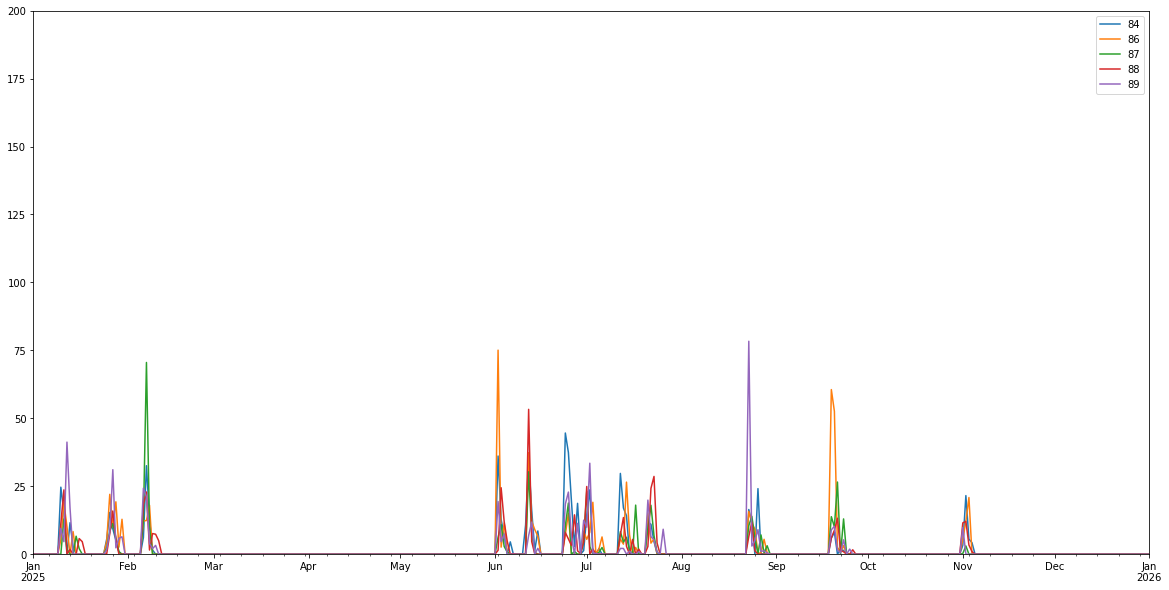

In [59]:
SIM1.Daily_Simulation.plot(figsize=(20, 10), xlim=['2025-01-01', '2026-01-01'], ylim=[0, 200])

In [ ]:
Input_Series.astype(float).corr()

,84,86,87,88,89
84,1.000000,0.699149,0.667550,0.531197,0.711733
86,0.699149,1.000000,0.759064,0.576975,0.784716
87,0.667550,0.759064,1.000000,0.601514,0.700415
88,0.531197,0.576975,0.601514,1.000000,0.525194
89,0.711733,0.784716,0.700415,0.525194,1.000000


In [61]:
SIM1.Daily_Simulation.astype(float).corr()

,84,86,87,88,89
84,1.000000,0.532860,0.540076,0.548624,0.527844
86,0.532860,1.000000,0.650927,0.531981,0.572549
87,0.540076,0.650927,1.000000,0.545133,0.578068
88,0.548624,0.531981,0.545133,1.000000,0.564859
89,0.527844,0.572549,0.578068,0.564859,1.000000


In [62]:
SIM1.crosscorr_Simulated

{'crosscorr_1': {(1,
   2,
   3):         dist  cross_corr
  0   2.436923    0.753124
  1   7.310770    0.595240
  2  12.184617    0.564315
  3  17.058463    0.558258
  4  21.932310    0.557072
  5  26.806156    0.556839
  6  31.680003    0.556794
  7  36.553850    0.556785
  8  41.427696    0.556783
  9  46.301543    0.556783,
  (4,
   5,
   6):         dist  cross_corr
  0   2.436923    0.730853
  1   7.310770    0.576475
  2  12.184617    0.550789
  3  17.058463    0.546516
  4  21.932310    0.545805
  5  26.806156    0.545686
  6  31.680003    0.545667
  7  36.553850    0.545664
  8  41.427696    0.545663
  9  46.301543    0.545663,
  (7,
   8,
   9):         dist  cross_corr
  0   2.436923     0.55952
  1   7.310770     0.55952
  2  12.184617     0.55952
  3  17.058463     0.55952
  4  21.932310     0.55952
  5  26.806156     0.55952
  6  31.680003     0.55952
  7  36.553850     0.55952
  8  41.427696     0.55952
  9  46.301543     0.55952,
  (10,
   11,
   12):         dist  cros

In [47]:
SIM1.save_files('./SIM_SN/')

In [48]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 648.6139557361603 seconds ---
